<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Électrocinétique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Électrocinétique numérique | Filtrage numérique
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Signal numérique bruité
Un signal numérique est généralement le résultat d'une acquisition d'un signal physique par un transducteur, sur une durée fini $T_\text{mes}$, il comporte généralement une partie informative, qui est plus ou moins masquée par du bruit.

&nbsp; 
On génère donc un signal numérique dont la partie informative sera une somme de sinusoïdes de fréquences $f_1$, $f_2$ et $f_3$, sur lequel on rajoute un bruit d'amplitude non négligeable, et de fréquence variable centrée autour de $f_b=2 f_3$. Ce signal sera calculé via la fonction `sin_bruit()` qui prendra pour argument l'array `t`, qui représente l'intervalle de temps de l'acquisition, ainsi qu'un réel `T`, période du fondamental.

&nbsp;
On commence par tracer la fonction `sin_bruit` pour toute valeur de `Tmes = 50*T` ainsi que le signal non bruité, calculé par la fonction `sin_ref`, pour comparaison.

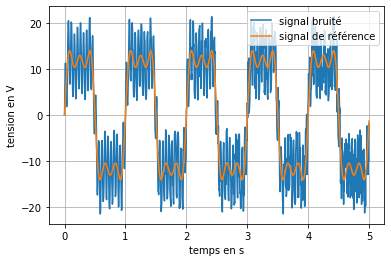

In [2]:
A = 15.
T = 1.
Tmes = 50*T
Num = 10000

t = np.linspace(0,Tmes,Num)

def sin_bruit(t, T):
    delta_f = .1*(np.random.rand(len(t))-.5)
    bruit = A/2*np.sin(2*np.pi*(20+delta_f)*t/T)
    return A*np.sin(2*np.pi*t/T) + A*np.sin(2*np.pi*3*t/T)/3 + A*np.sin(2*np.pi*5*t/T)/5 + bruit

def sin_ref(t, T):
    return A*np.sin(2*np.pi*t/T) + A*np.sin(2*np.pi*3*t/T)/3 + A*np.sin(2*np.pi*5*t/T)/5

signal = sin_bruit(t,T)

plt.figure()
plt.plot(t[:Num//10],signal[:Num//10], label='signal bruité')
plt.plot(t[:Num//10],sin_ref(t,T)[:Num//10], label='signal de référence')
plt.legend()
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.grid(True)
plt.show()

On peut ensuite tracer le spectre du signal bruité et le comparer à celui du signal de référence en utilisant la fonction `fft.rfft()` déjà utilisée dans le notebool sur la <a href="https://mybinder.org/v2/gh/CCayssiols/CN_PT_Fourier/HEAD" target="_blank">transformée de Fourier discrète</a>.

In [3]:
y = np.fft.rfft(signal/(Num//2+1))
y_ref = np.fft.rfft(sin_ref(t,T)/(Num//2+1))
freq_k = np.array([i/Tmes for i in range(len(y))])

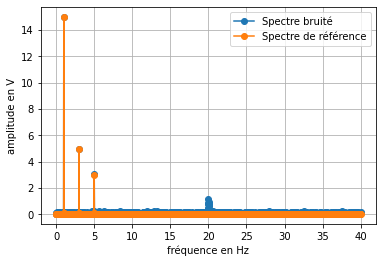

In [4]:
plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k[:Num//5],np.abs(y)[:Num//5],'-o',label='Spectre bruité')
plt.plot(freq_k[:Num//5],np.abs(y_ref)[:Num//5],'-o',label='Spectre de référence')
plt.legend()
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.grid(True)
plt.show()

On remarque la présence d'un pic à $f=20~\text{Hz}$, d'amplitude non négligeable, qui signale la présence du bruit dans le signal utile.

### Filtre numérique passe-bas
Pour se débarrasser de ce bruit, on peut filtrer le signa *avant* acquisition, mais on peut également le faire *après* acquisition en créant un filtre numérique passe-bas.

&nbsp;
Ce filtre numérique s'appuie sur la fonction de transfert d'un filtre passe-bas du premier ordre par exemple : 
$$\underline{H}=\dfrac{\underline{s}}{\underline{e}}=\dfrac{1}{1-\text{j}\frac{\omega}{\omega_c}}$$

&nbsp;
Dans le domaine temporel, ceci revient à résoudre l'équation différentielle : 
$$u_e(t)=u_s(t)+\dfrac{1}{\omega_c}\dfrac{\text{d}u_s}{\text{d}t}$$

&nbsp;
Cette résolution peu se faire via la méthode d'Euler, soit : 
$$e[i]=s[i]+\dfrac{s[i+1]-s[i]}{\omega_c\Delta t}$$

&nbsp;
Dont on tire la relation de récurrence : 
$$s[i+1]=s[i]+2\pi f_c\Delta t (e[i]-s[i])$$

&nbsp;
La connaissance de $s[0]$ permet de déduire toutes les valeurs $s[i]$ du signal filtré numériquement. 

&nbsp;
C'est cette approche qui est codée dans la fonction `filtre_PB_1o()`, prenant pour argument le signal numérique acquis `s_num`, ainsi que la fréquence de coupure `f_c` choisie.</br>

Un filtre d'ordre 2 a également été codé dans la fonction `filtre_PB_2o()` pour comparaison. Cette fonction prend les mêmes arguments, auxquels on rajoute le facteur de qualité $Q$.

In [5]:
def filtre_PB_1o(s_num,f_c):
    Na=len(s_num) 
    s_filtre=np.array([i for i in s_num])
    for i in range(Na-1) :
        s_filtre[i+1]=s_filtre[i]+2*np.pi*f_c*Tmes*(s_num[i]-s_filtre[i])/(Na-1) 
    return s_filtre

def filtre_PB_2o(s_num,f_c,Q):
    Na=len(s_num) 
    dt = Tmes/(Na-1)
    s_filtre=np.array([i for i in s_num])
    for i in range(1,Na-1) :
        s_filtre[i+1]=(s_num[i]-s_filtre[i]+s_filtre[i]/(2*np.pi*f_c*dt*Q)+2*s_filtre[i]/((2*np.pi*f_c*dt)**2)-s_filtre[i-1]/((2*np.pi*f_c*dt)**2))/(1/((2*np.pi*f_c*dt)**2)+1/(2*np.pi*f_c*dt*Q))
    return s_filtre

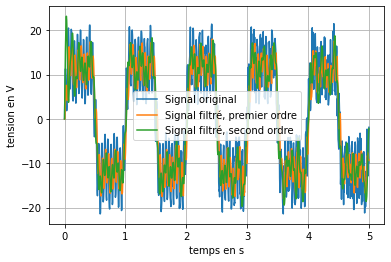

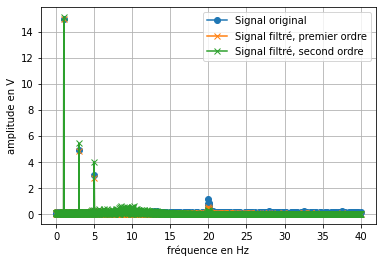

In [6]:
signal_filtre_1o = filtre_PB_1o(signal,10)
signal_filtre_2o = filtre_PB_2o(signal,10,3)

plt.figure()
plt.plot(t[:Num//10],signal[:Num//10], label='Signal original')
plt.plot(t[:Num//10],signal_filtre_1o[:Num//10], label='Signal filtré, premier ordre')
plt.plot(t[:Num//10],signal_filtre_2o[:Num//10], label='Signal filtré, second ordre')
plt.legend()
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.grid(True)
plt.show()

y_filtre_1o = np.fft.rfft(signal_filtre_1o/(Num//2+1))
y_filtre_2o = np.fft.rfft(signal_filtre_2o/(Num//2+1))
freq_k = np.array([i/Tmes for i in range(len(y))])

plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k[:Num//5],np.abs(y)[:Num//5],'-o', label='Signal original')
plt.plot(freq_k[:Num//5],np.abs(y_filtre_1o)[:Num//5],'-x', label='Signal filtré, premier ordre')
plt.plot(freq_k[:Num//5],np.abs(y_filtre_2o)[:Num//5],'-x', label='Signal filtré, second ordre')
plt.legend()
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.grid(True)
plt.show()

On remarque que le filtre passe-bas d'ordre 1 respecte bien les amplitudes du fondamental et de ses harmoniques mais n'atténue que de moitié l'amplitude du bruit.

&nbsp;
Le filtre d'ordre 2 donne un résultat surprenant. Si l'amplitude du bruit est bien plus atténuée qu'avec le filtre d'ordre 1, les harmoniques d'ordre 3 et 5 sont amplifiées et une zone de bruit, plus ou moins centrée autour de la fréquence de coupure, a également été amplifiée.

&nbsp;
Ce constat s'explique simplement avec le tracé du diagramme de Bode de ce filtre d'ordre 2 ou l'on a également précisé les fréquences à conserver et celle à réduire.
<img src="fig1.png" style="height:350px">

&nbsp;
On voit que le fondamental n'est pas affecté par le filtre, que les harmoniques 3 et surtout 5 sont amplifiées, et que le bruit à $20~\text{Hz}$ est atténué d'un facteur $10^{-0,5}\simeq 0,3$.

### Limitation due à la fréquence d'échantillonnage

Le signal numérisé utilisé ici a été acquis à la fréquence d'échantillonnage $f_e=\frac{\text{Num}}{T_\text{mes}}= 200~\text{Hz}$.

&nbsp;
Supposons que le signal acquis soit perturbé par un bruit de fréquence inconnue, supérieure à celle de la fréquence d'échantillonnage, par exemple ici $f_b=353~\text{Hz}$. Il donne le signal échantillonné suivant :

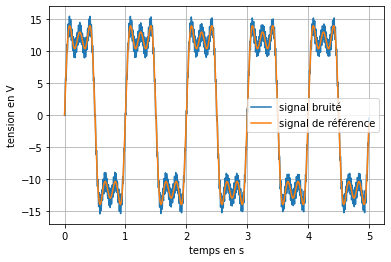

In [7]:
A = 15.
T = 1.
Tmes = 50*T
Num = 10000

t = np.linspace(0,Tmes,Num)

def sin_bruit(t, T):
    return A*np.sin(2*np.pi*t/T) + A*np.sin(2*np.pi*3*t/T)/3 + A*np.sin(2*np.pi*5*t/T)/5 + A*np.sin(2*np.pi*353*t/T)/10

def sin_ref(t, T):
    return A*np.sin(2*np.pi*t/T) + A*np.sin(2*np.pi*3*t/T)/3 + A*np.sin(2*np.pi*5*t/T)/5

signal = sin_bruit(t,T)

plt.figure()
plt.plot(t[:Num//10],signal[:Num//10], label='signal bruité')
plt.plot(t[:Num//10],sin_ref(t,T)[:Num//10], label='signal de référence')
plt.legend()
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.grid(True)
plt.show()

On cherche alors à déterminer la fréquence de ce bruit en calculant son spectre via la transformée de Fourier utilisée jusqu'à maintenant.

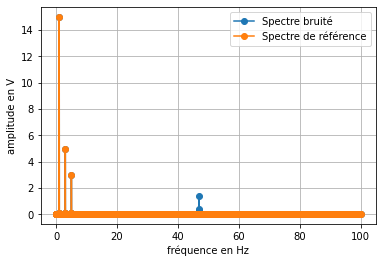

In [8]:
y = np.fft.rfft(signal/(Num//2+1))
y_ref = np.fft.rfft(sin_ref(t,T)/(Num//2+1))
freq_k = np.array([i/Tmes for i in range(len(y))])

plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k,np.abs(y),'-o',label='Spectre bruité')
plt.plot(freq_k,np.abs(y_ref),'-o',label='Spectre de référence')
plt.legend()
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.grid(True)
plt.show()

La fréquence affichée du bruit n'est pas $f_b=353~\text{Hz}$ mais plutôt $f_b=47~\text{Hz}$.

&nbsp;
On retrouve un aspect bien connu des acquisitions numériques : le *repliement spectral*. Ici la fréquence du bruit est supérieure à celle de l'échantillonnage et son acquisition ne respecte donc pas le critère de Shannon. Le pic observé est le résultat d'un repliement spectral et se trouve donc à la fréquence :
$$f_{rs}=f_b-f_e=47~\text{Hz}$$

&nbsp;
On peut bien sûr filtrer a posteriori cette fréquence avec les filtres numériques précédemment développés, mais pour celà il faut d'abord connaître la fréquence de repliement et donc la fréquence du bruit de départ ce qui n'est généralement pas le cas.

&nbsp;
La seule façon de ne pas se retrouver dans une telle situation est de filtre le signal avant acquistion, avec un filtre de fréquence de coupure inférieure à la fréquence limite du critère de Shannon.